In [18]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import wandb
import gym
import matplotlib.pyplot as plt
from numpy import savetxt

In [14]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
                                   input_dims=input_dims,
                                   fc1_dims=256, fc2_dims=256)
        self.state_memory = np.zeros((self.mem_size, *input_dims),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(
                self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(
                self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(
                self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

In [49]:
def plotLearning(x, scores, epsilons, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)


In [15]:
##Lunar Lander

env = gym.make("LunarLander-v2")
lr = 0.001
agent = Agent(gamma = 0.9, epsilon = 1.0, batch_size = 64, n_actions = 4, eps_end = 0.05, input_dims = [8], lr = lr)
scores, eps_history, smoothed_returns = [], [], []
n_games = 500
wandb.init(project = "DQN-Lunar_final", name = f"DQN Lunar_final {lr}")

for i in range(n_games):

    
    score = 0
    done = False
    observation = env.reset()
    while not done:
        #env.render()
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    avg_score = np.mean(scores[-100:])
    smoothed_returns.append(avg_score)
    
    
    print('episode ', i, 'score %.2f' % score,
                
                'epsilon %.2f' % agent.epsilon,
                 'avscore %.2f' % avg_score)
    
    
    wandb.log({'Reward':score, 'Average reward':avg_score}, step = i)

    
x = [i+1 for i in range(n_games)]

Average reward,▁▂▂▂▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
Reward,▂▁▂▅▅▅▆▅▄▆▆▅▆▇▇▄▇▆▆▅█▄▃▃▄▄▅▇▄▄▄▇▃▆▅▅▅▅▅▅
Average reward,-98.52973
Reward,-106.9644


episode  0 score -134.30 epsilon 0.99 avscore -134.30
episode  1 score -278.04 epsilon 0.94 avscore -206.17
episode  2 score -136.16 epsilon 0.89 avscore -182.83
episode  3 score -66.94 epsilon 0.83 avscore -153.86
episode  4 score -93.74 epsilon 0.75 avscore -141.84
episode  5 score -151.32 epsilon 0.68 avscore -143.42
episode  6 score -78.31 epsilon 0.63 avscore -134.11
episode  7 score -328.31 epsilon 0.58 avscore -158.39
episode  8 score -194.62 epsilon 0.49 avscore -162.41
episode  9 score -81.19 epsilon 0.43 avscore -154.29
episode  10 score -110.41 epsilon 0.35 avscore -150.30
episode  11 score -81.87 epsilon 0.19 avscore -144.60
episode  12 score -81.70 epsilon 0.05 avscore -139.76
episode  13 score -222.42 epsilon 0.05 avscore -145.67
episode  14 score -278.83 epsilon 0.05 avscore -154.54
episode  15 score -117.91 epsilon 0.05 avscore -152.25
episode  16 score -158.58 epsilon 0.05 avscore -152.62
episode  17 score 261.01 epsilon 0.05 avscore -129.65
episode  18 score -32.05 ep

episode  150 score 297.27 epsilon 0.05 avscore -76.00
episode  151 score -191.68 epsilon 0.05 avscore -76.36
episode  152 score -168.34 epsilon 0.05 avscore -77.18
episode  153 score -26.07 epsilon 0.05 avscore -75.96
episode  154 score -148.38 epsilon 0.05 avscore -76.50
episode  155 score -18.86 epsilon 0.05 avscore -74.78
episode  156 score 183.74 epsilon 0.05 avscore -71.35
episode  157 score 210.67 epsilon 0.05 avscore -68.60
episode  158 score -62.24 epsilon 0.05 avscore -66.72
episode  159 score -68.88 epsilon 0.05 avscore -66.04
episode  160 score 13.22 epsilon 0.05 avscore -65.26
episode  161 score -199.31 epsilon 0.05 avscore -66.49
episode  162 score 10.00 epsilon 0.05 avscore -66.02
episode  163 score 216.18 epsilon 0.05 avscore -62.59
episode  164 score 196.07 epsilon 0.05 avscore -59.72
episode  165 score 248.93 epsilon 0.05 avscore -55.31
episode  166 score -145.52 epsilon 0.05 avscore -55.38
episode  167 score -119.28 epsilon 0.05 avscore -55.14
episode  168 score -68.4

episode  301 score -57.43 epsilon 0.05 avscore -20.62
episode  302 score -52.77 epsilon 0.05 avscore -20.61
episode  303 score 186.66 epsilon 0.05 avscore -17.31
episode  304 score 184.25 epsilon 0.05 avscore -14.70
episode  305 score 126.78 epsilon 0.05 avscore -12.31
episode  306 score -34.91 epsilon 0.05 avscore -11.27
episode  307 score -245.23 epsilon 0.05 avscore -12.88
episode  308 score -32.26 epsilon 0.05 avscore -11.89
episode  309 score 156.87 epsilon 0.05 avscore -9.46
episode  310 score 76.55 epsilon 0.05 avscore -7.49
episode  311 score -775.77 epsilon 0.05 avscore -14.20
episode  312 score -32.14 epsilon 0.05 avscore -13.81
episode  313 score -85.35 epsilon 0.05 avscore -14.40
episode  314 score -108.31 epsilon 0.05 avscore -14.87
episode  315 score -69.63 epsilon 0.05 avscore -14.70
episode  316 score -44.30 epsilon 0.05 avscore -14.39
episode  317 score 251.02 epsilon 0.05 avscore -11.91
episode  318 score -19.82 epsilon 0.05 avscore -11.60
episode  319 score 218.61 ep

episode  454 score -103.24 epsilon 0.05 avscore 6.75
episode  455 score -5.24 epsilon 0.05 avscore 4.14
episode  456 score -65.21 epsilon 0.05 avscore 1.09
episode  457 score -39.18 epsilon 0.05 avscore -0.99
episode  458 score -76.57 epsilon 0.05 avscore -1.98
episode  459 score -98.48 epsilon 0.05 avscore -2.58
episode  460 score -83.68 epsilon 0.05 avscore -3.78
episode  461 score -119.68 epsilon 0.05 avscore -4.27
episode  462 score -135.51 epsilon 0.05 avscore -5.37
episode  463 score -37.49 epsilon 0.05 avscore -5.12
episode  464 score -110.20 epsilon 0.05 avscore -5.32
episode  465 score -22.10 epsilon 0.05 avscore -5.50
episode  466 score 25.92 epsilon 0.05 avscore -3.94
episode  467 score -91.78 epsilon 0.05 avscore -3.85
episode  468 score -101.44 epsilon 0.05 avscore -3.88
episode  469 score -108.64 epsilon 0.05 avscore -3.77
episode  470 score -98.75 epsilon 0.05 avscore -3.57
episode  471 score -95.10 epsilon 0.05 avscore -3.34
episode  472 score -64.23 epsilon 0.05 avscor

In [20]:
savetxt("lunar_dqn_returns.csv", scores, delimiter = ',')

In [21]:
savetxt("lunar_dqn_av_returns.csv", smoothed_returns, delimiter = ',')


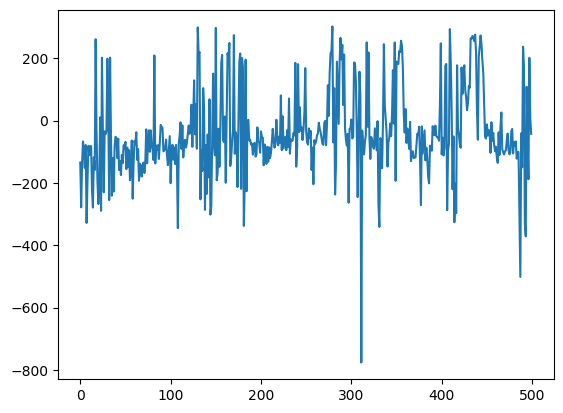

In [23]:
plt.plot(scores)
plt.show()